In [1]:
import os 
import sys
from os import listdir
from os.path import isfile, join
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import skimage
from skimage import io, color, exposure
from skimage.util import img_as_ubyte
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from pathlib import Path
import re
import h5py
from scipy import signal
import scipy.ndimage
import seaborn as sns
import pandas as pd
import scanpy as sc
import anndata as ad

from matplotlib.pyplot import rc_context
sc.settings.verbosity = 3


In [2]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / 'data'

In [3]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)



# Read images

In [4]:
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
fontprops = fm.FontProperties(size=50)

h5_data_dir = p_dir / 'data' / 'h5'

def get_imgs(experiment, name):
    with h5py.File(h5_data_dir / f'{experiment}.hdf5', 'r') as f:
        imgs = f[name][:]
        labels = list(f[name].attrs['labels'])
        fov = f[name].attrs['fov']
    return imgs, labels, fov

def contrast_stretching(img):
    # Contrast stretching
    p2, p98 = np.percentile(img, (0, 100))
    img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98), out_range = (0, 255)).astype(np.uint8)
    return img_rescale
    
def get_mass(file):
    labels = ['total', 'rest']
    with open(file) as infile:
        next(infile)
        for line in infile:
            mass = float(line.split("\t")[1])
            mass = np.round(mass, 1)
            labels.append(mass)
    return labels


def get_imgs_index(imgs, index_list):
    
    imgs_subset = imgs[index_list, :,:]
    img_combined = np.sum(imgs_subset, axis=0)
    return img_combined


In [5]:
# experiment = 'kidney'

# ts_data_dir = p_dir / 'data' / 'tof-sims' / experiment
# datasets = listdir(ts_data_dir)
# datasets = [dataset for dataset in datasets if 'auto' in dataset]

In [33]:
experiment = 'cnms_2'

ts_data_dir = p_dir / 'data' / 'tof-sims' / experiment
datasets = listdir(ts_data_dir)

In [34]:
datasets

['H02_Bi1_150um_Negative',
 'H02_Bi1_150um_Positive',
 'H02_Bi3++_Negative_100um',
 'H02_Bi3++_Negative_200um',
 'H02_Bi3++_Negative_50um',
 'H02_Bi3_150um_Negative',
 'H02_Bi3_Negative_100um',
 'H02_Bi3_Negative_100um_Ar_sputter',
 'H02_Bi3_Negative_200um',
 'H02_Bi3_Negative_50um',
 'H02_Bi3_Negative_50um_Ar_sputter_new_spot',
 'H02_Bi3_Positive_100um_Ar_sputter',
 'H02_Bi3_Positive_100um_Ar_sputter_new_spot',
 'H02_Bi3_Positive_50um_Ar_sputter',
 'H02_Bi3_Positive_50um_Ar_sputter_new_spot',
 'H02_Bi3_Positive_50um_no_sputter_new_spot']

In [41]:
datasets = ['H02_Bi3_Negative_100um',
 'H02_Bi3_Negative_100um_Ar_sputter',
 'H02_Bi3_Negative_50um',
 'H02_Bi3_Negative_50um_Ar_sputter_new_spot',]

H02_Bi3_Negative_100um


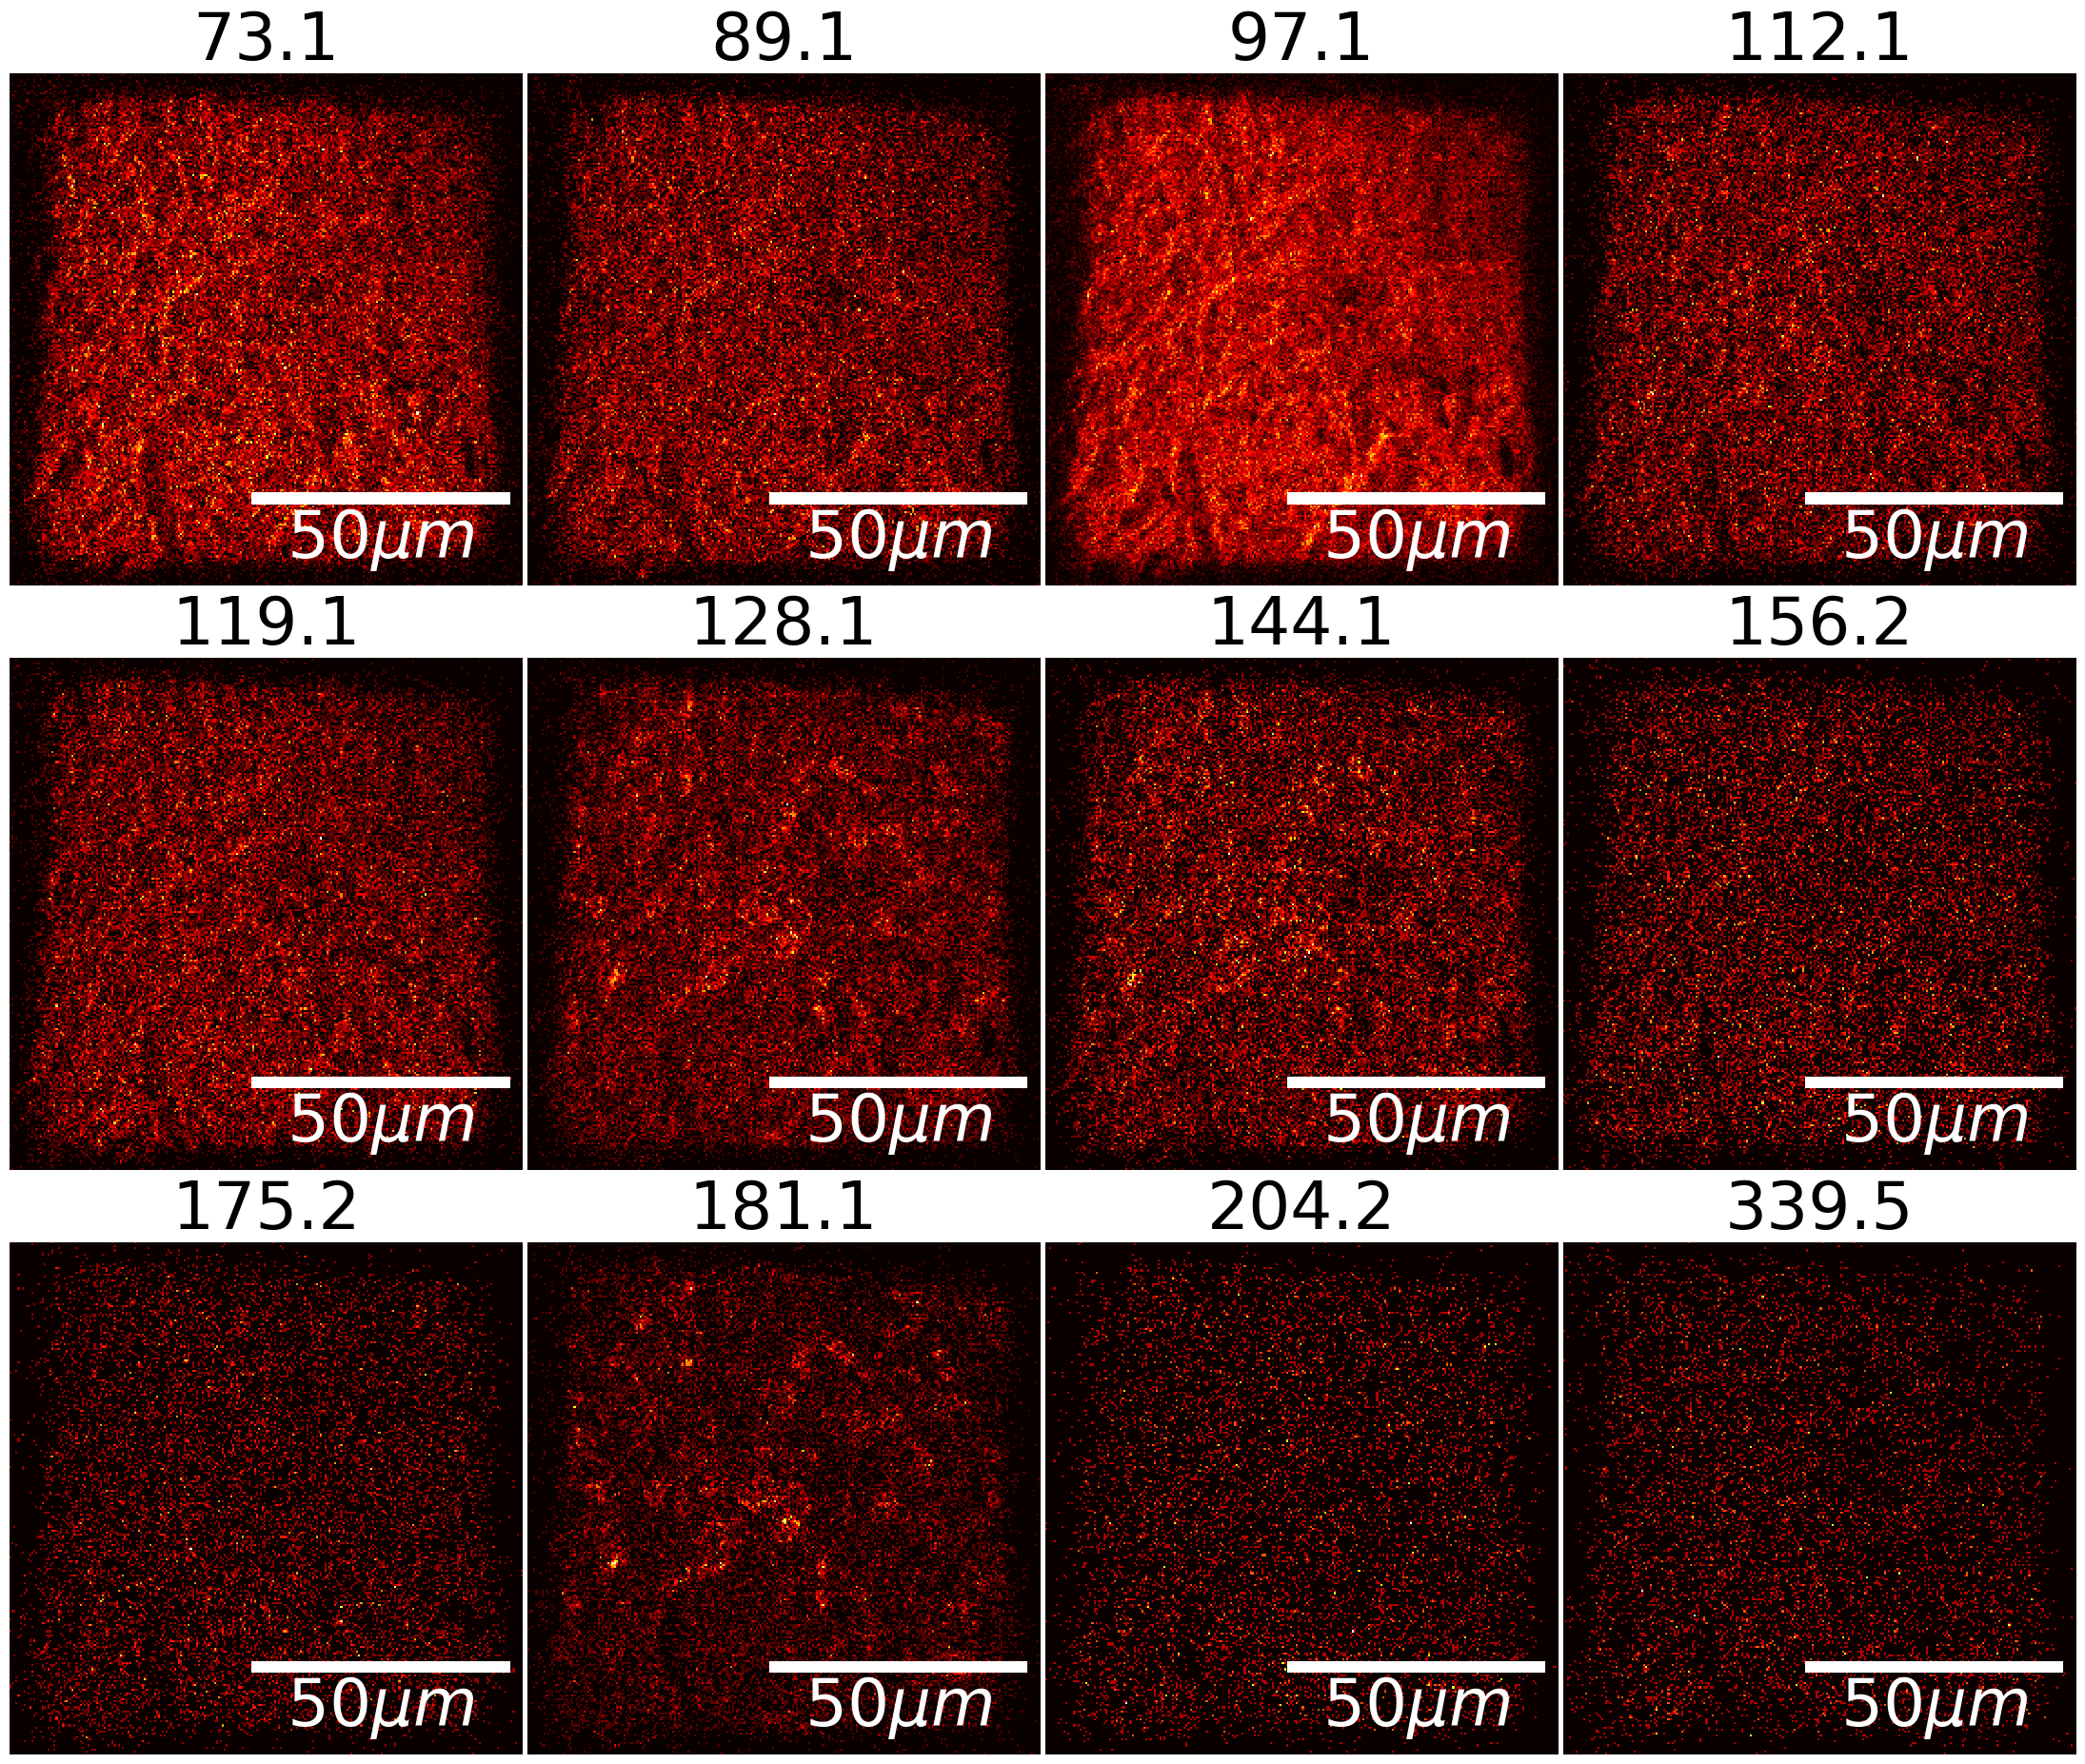

H02_Bi3_Negative_100um_Ar_sputter


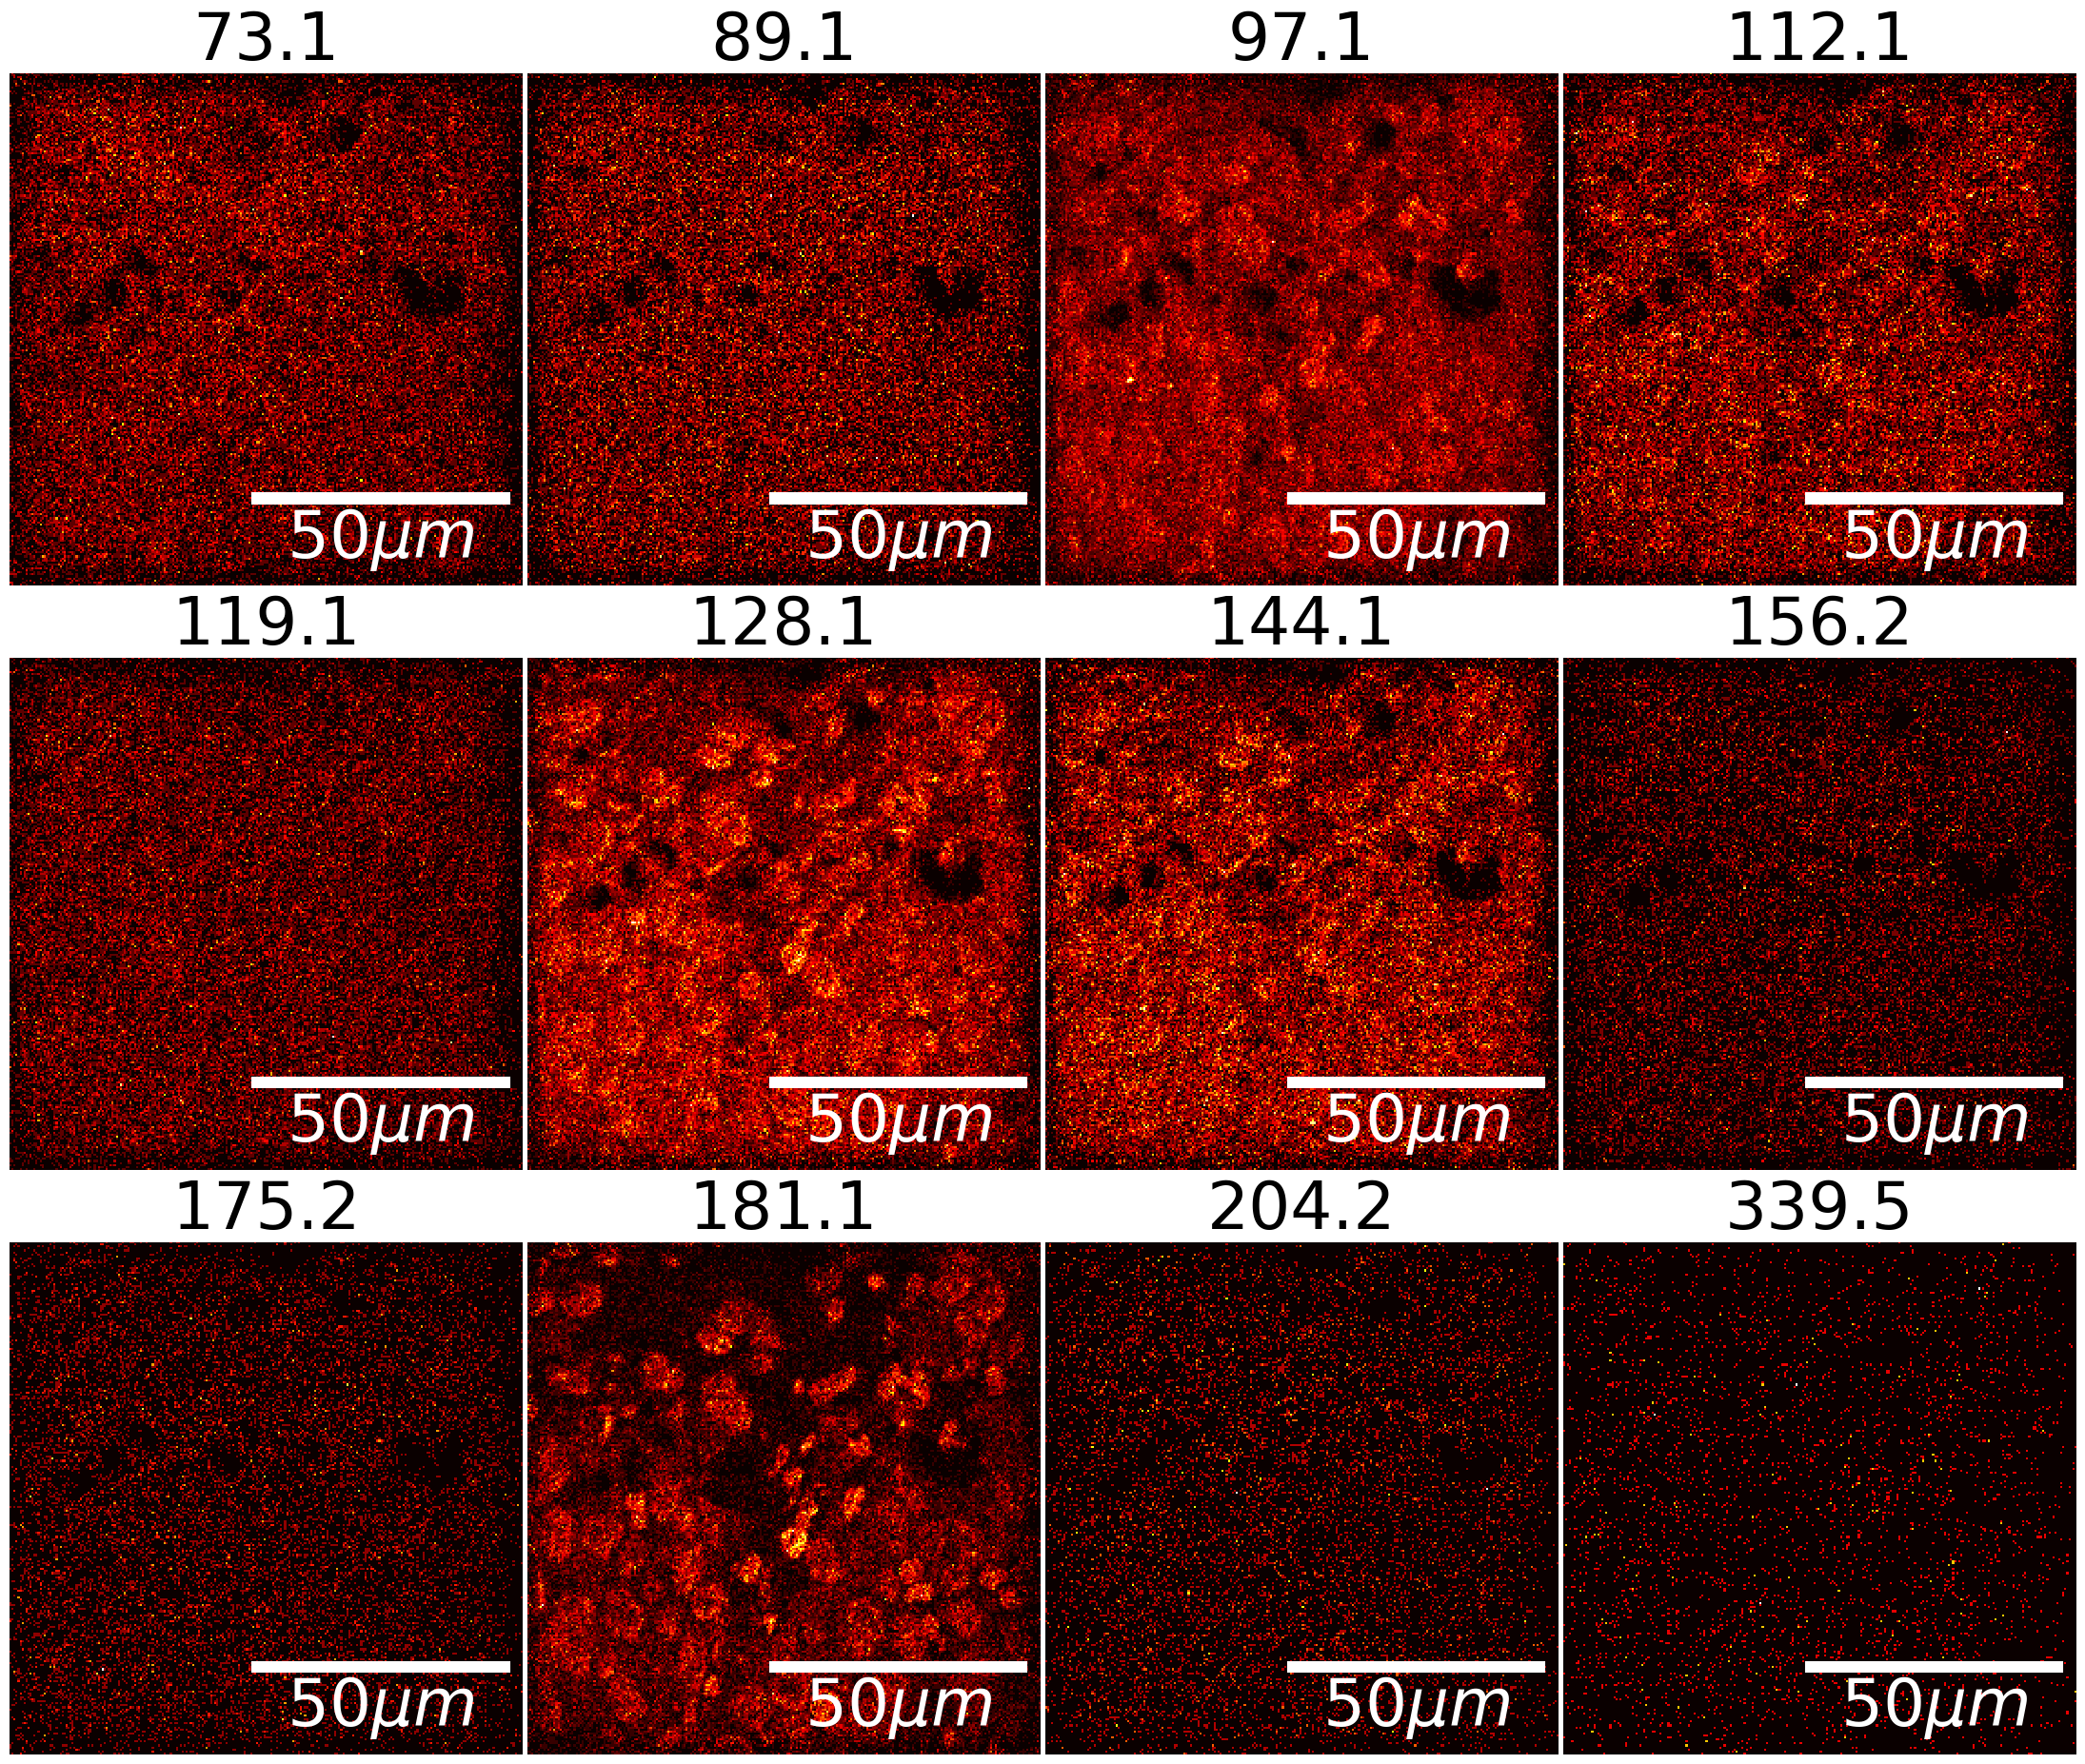

H02_Bi3_Negative_50um


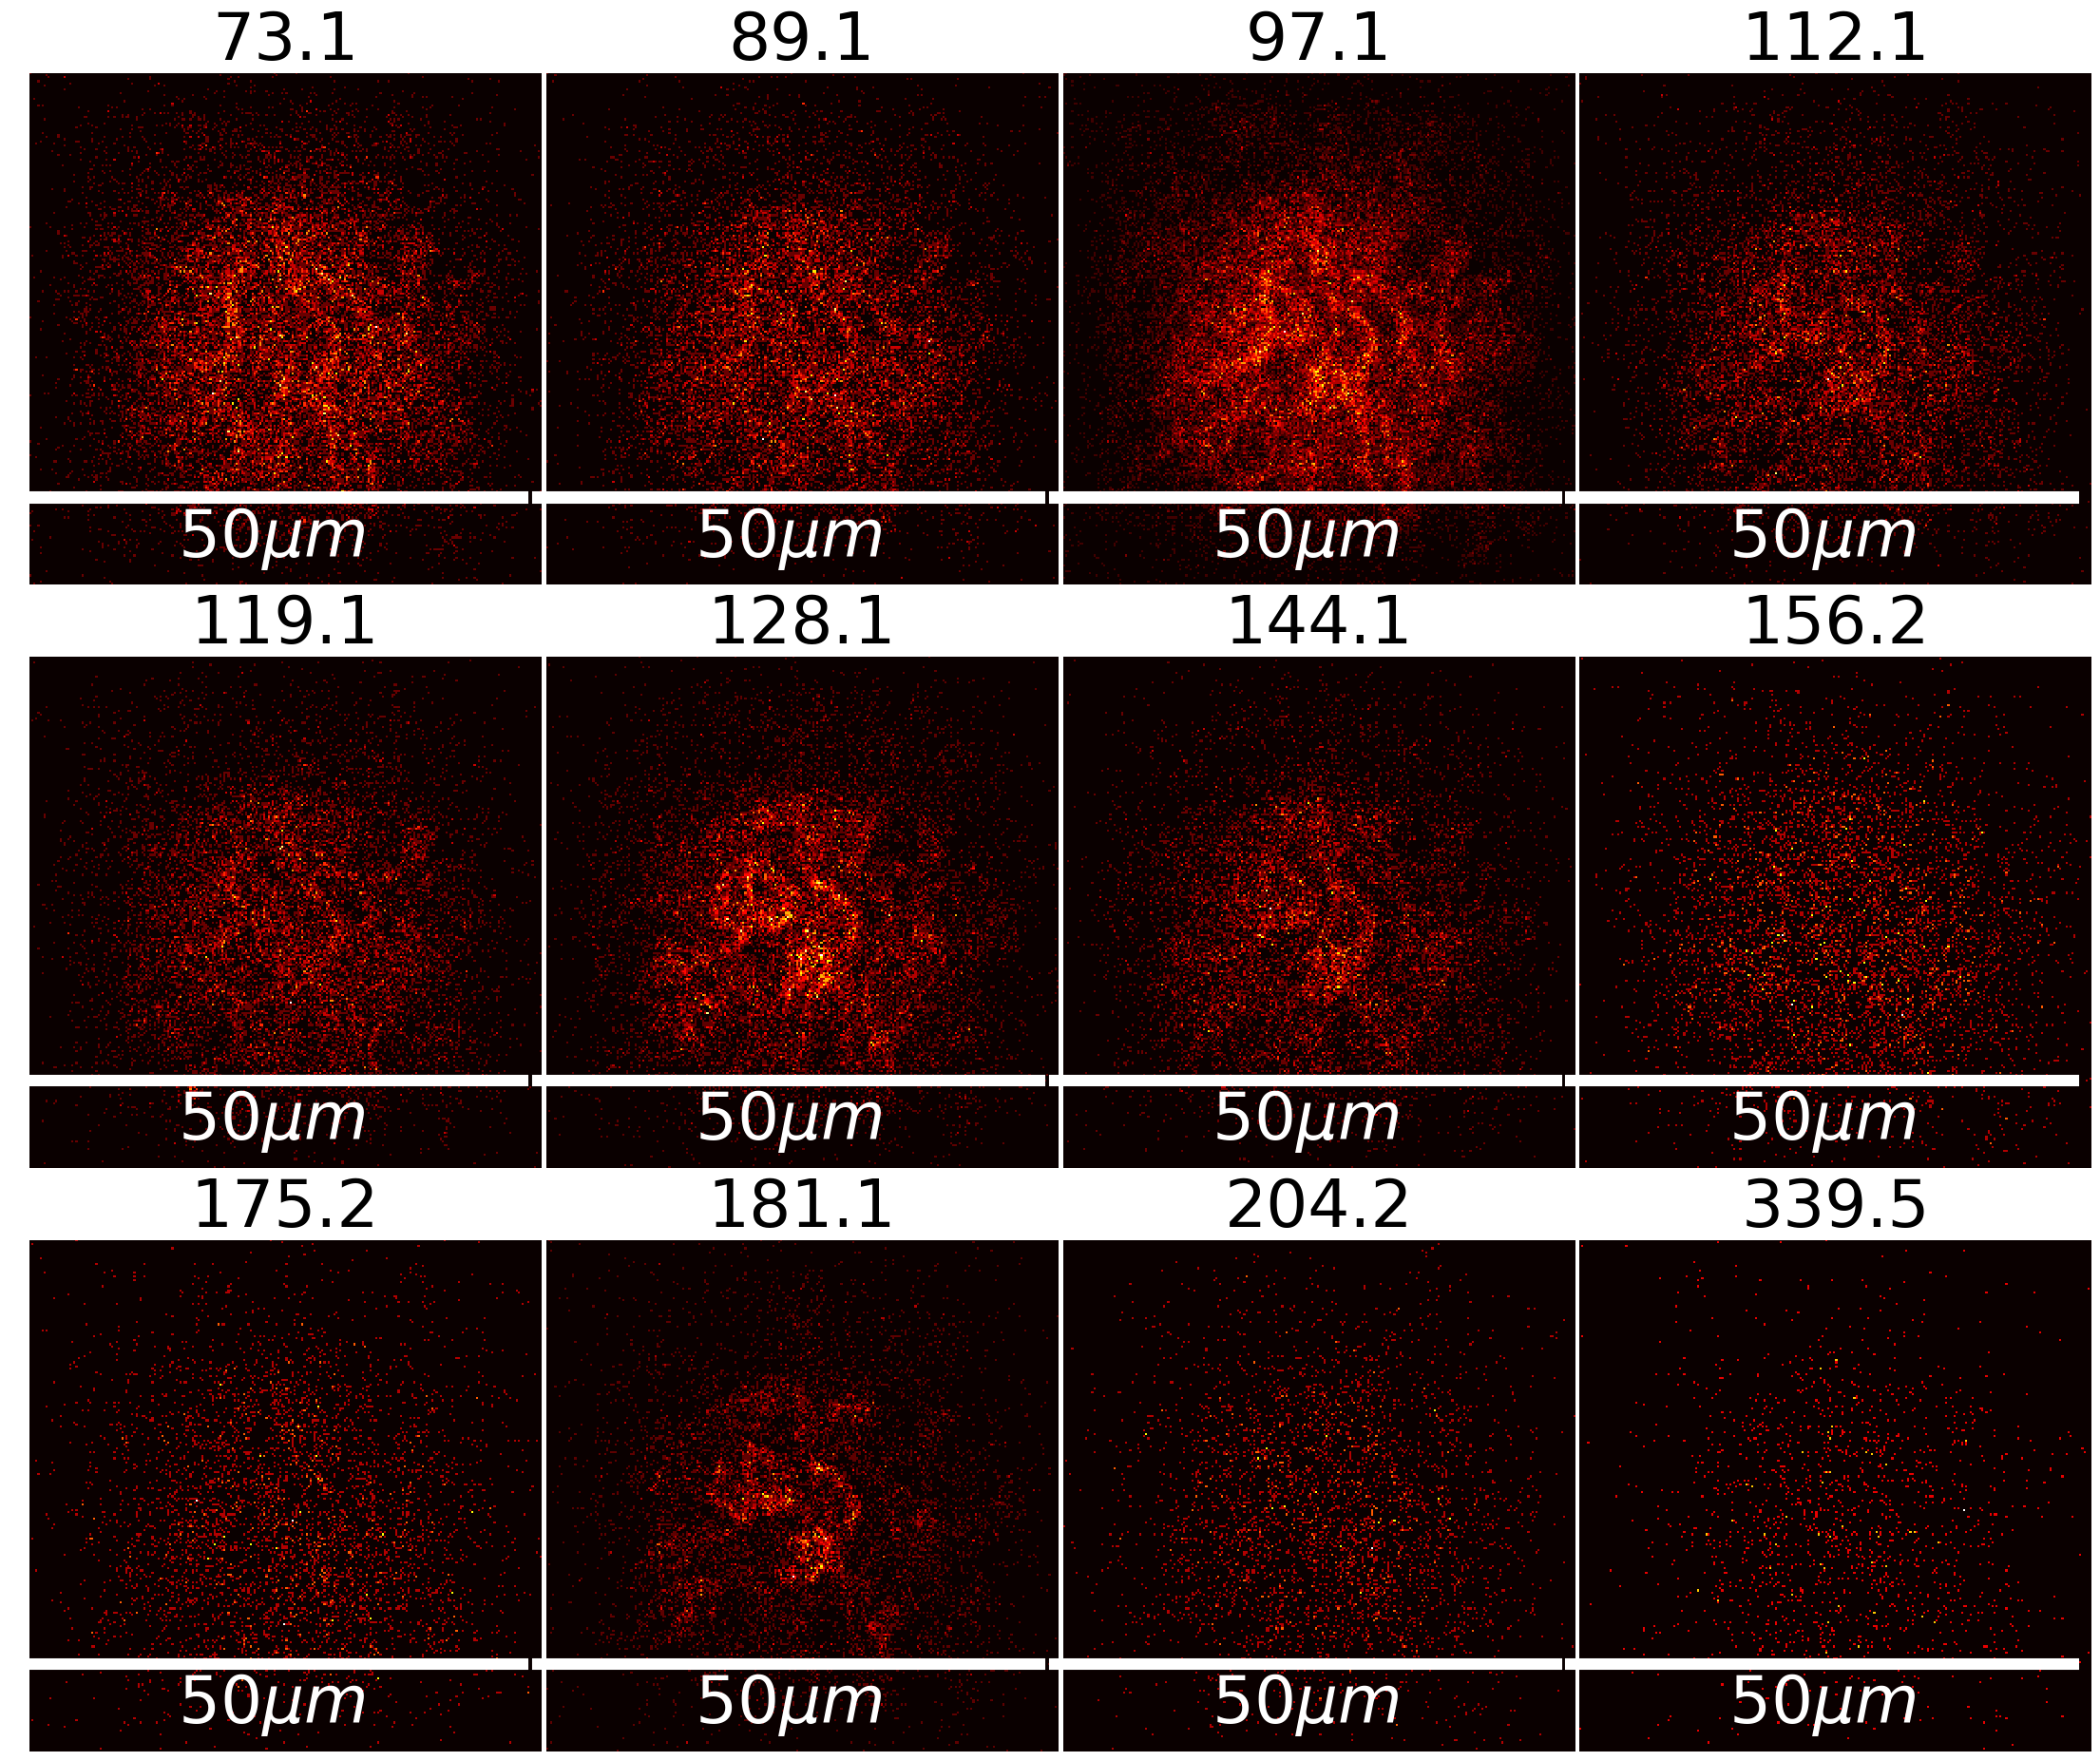

H02_Bi3_Negative_50um_Ar_sputter_new_spot


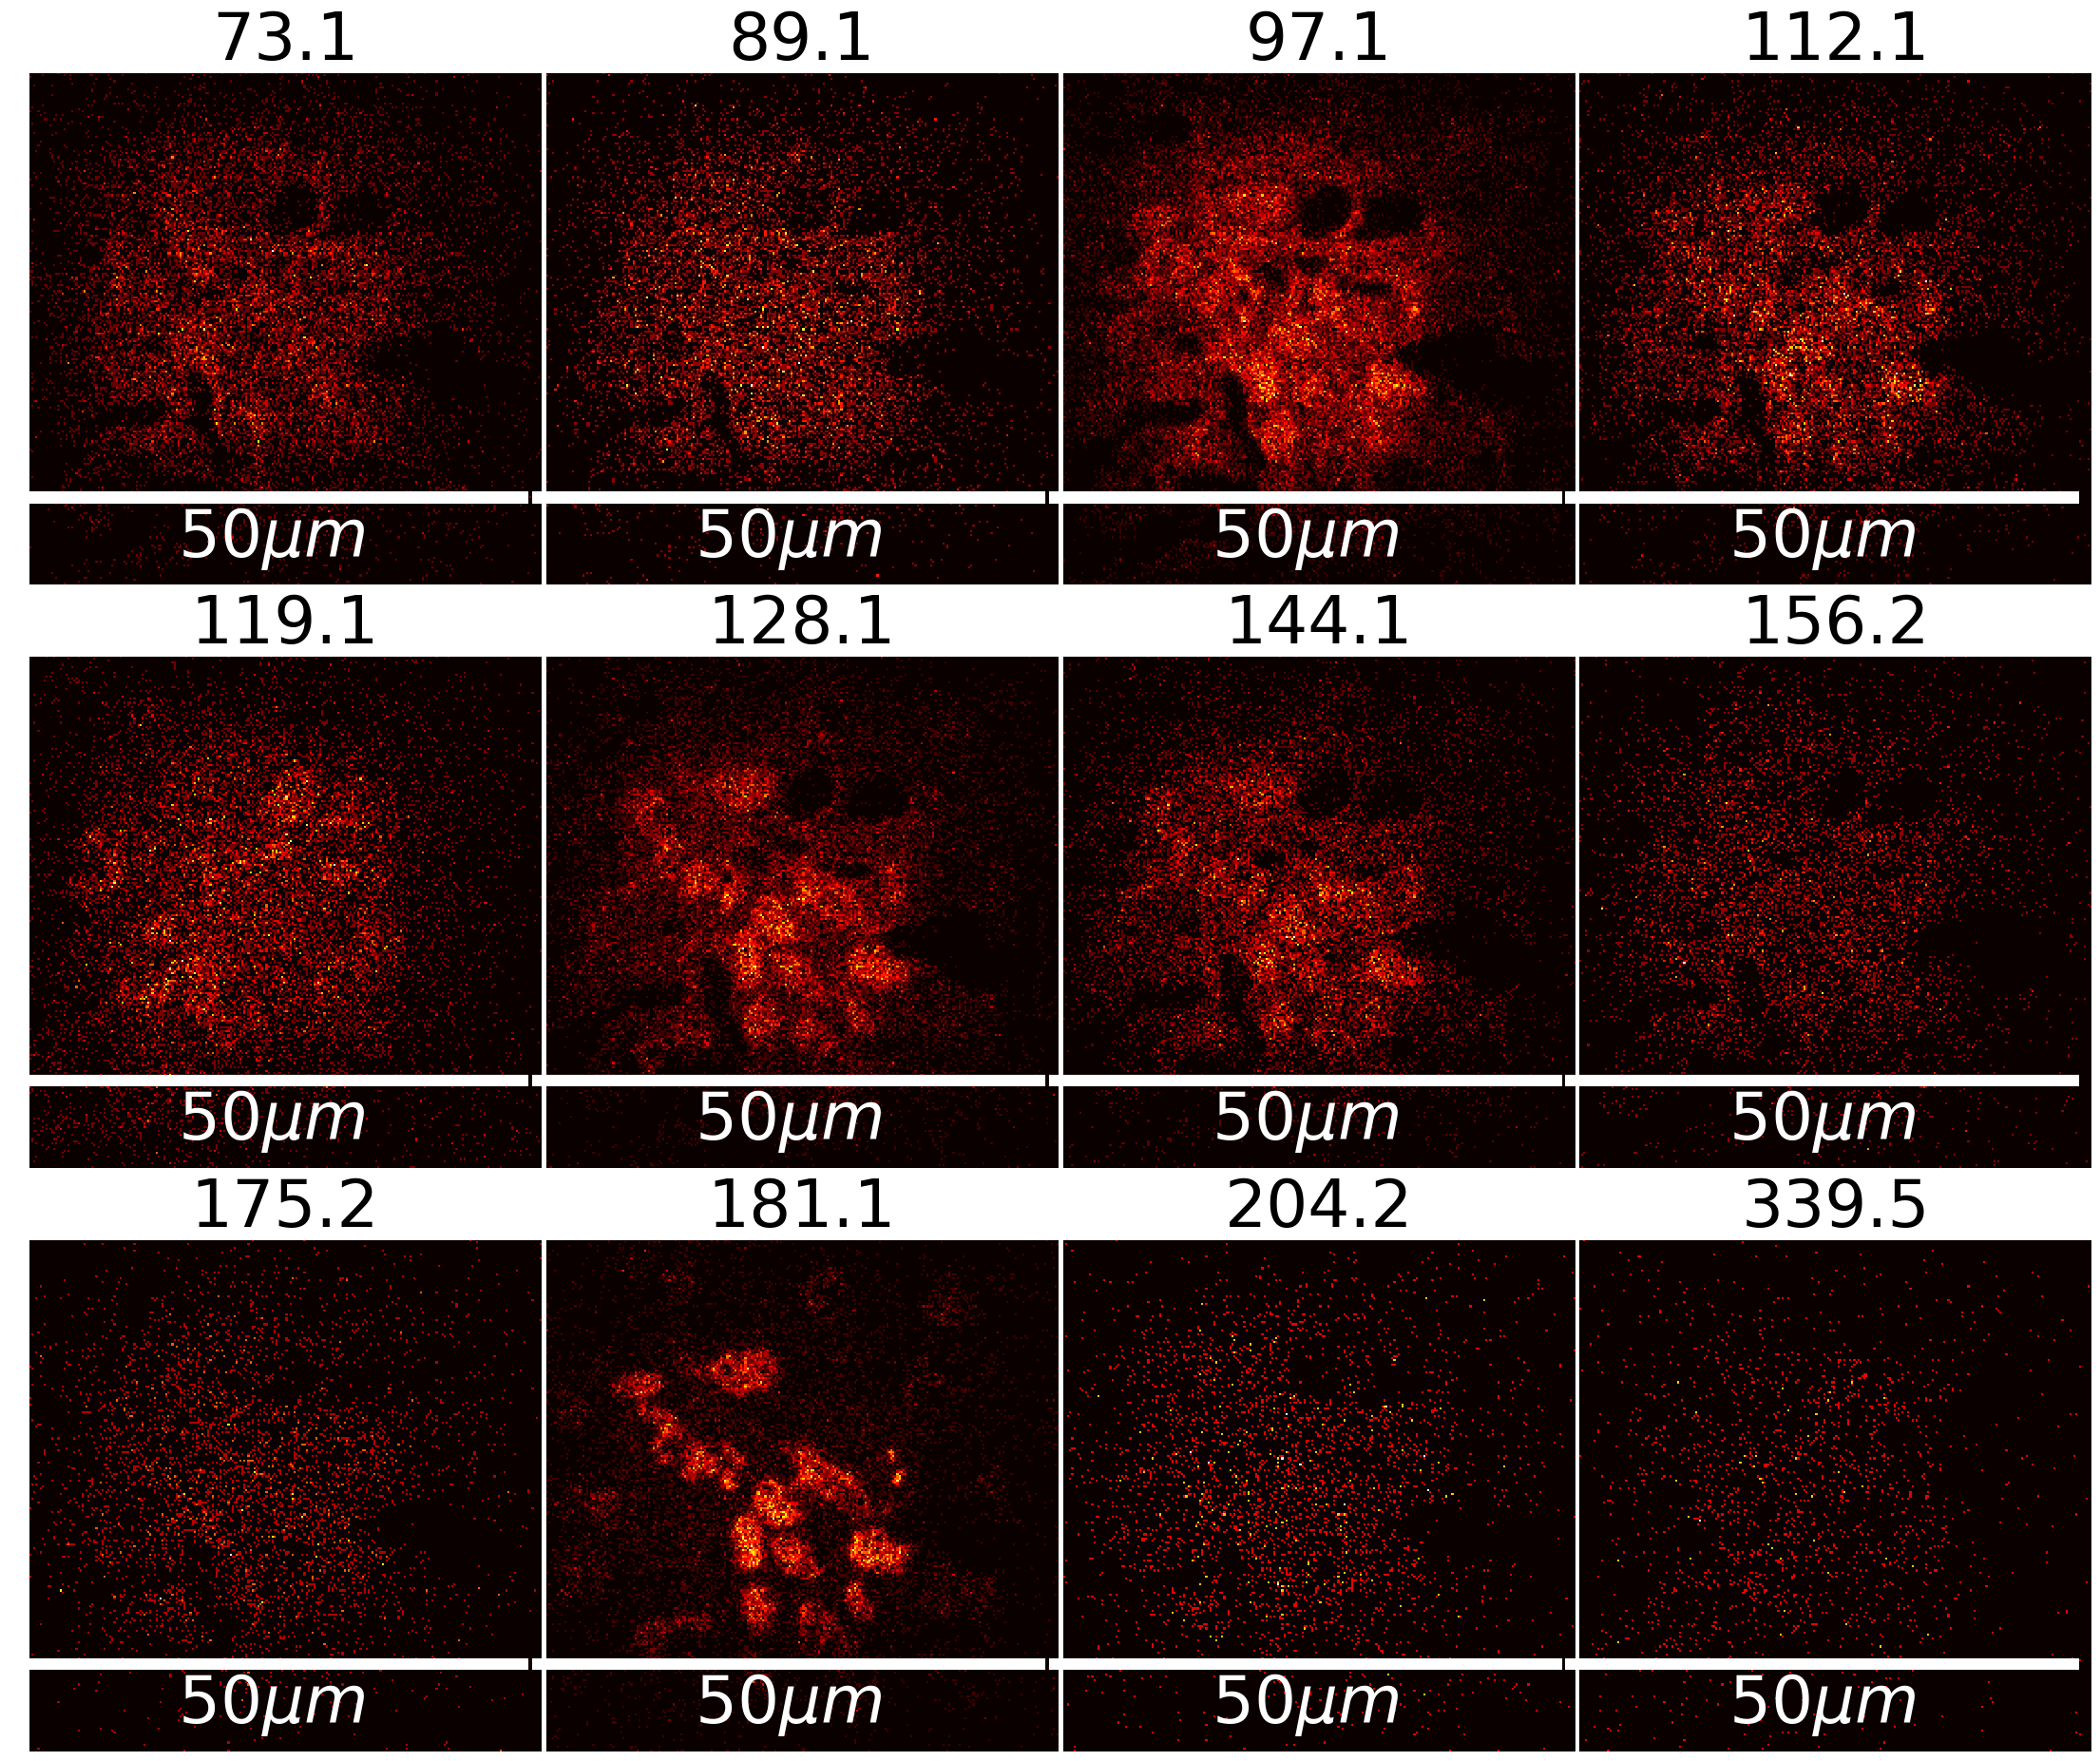

In [42]:
# subset = [0, 37, 54, 58, 74, 82, 97, 104, 113, 129, 141, 160, 166, 188, 204]
subset = [58, 74, 82, 97, 104, 113, 129, 141, 160, 166, 188, 204]


for dataset in datasets:
    # Read images and get PO3 channel
    print(dataset)
    try:
        imgs, labels, fov = get_imgs(experiment, dataset)
        imgs_subset = imgs[subset]
        labels_subset = [labels[i] for i in subset]

        size = imgs.shape[1]
        fig, axes = plt.subplots(3, 4, figsize=(28,23))
        axs = axes.flatten()
        for i, ax in enumerate(axs):
            ax.imshow(imgs_subset[i], cmap='hot', interpolation='none')
            ax.axis('off')
            ax.set_title(f'{float(labels_subset[i]):.1f}', size=50)
            scalebar = AnchoredSizeBar(ax.transData,
                                   50/(fov/size), r'$50  \mu m$', 'lower right', 
                                   pad=0.1,
                                   color='white',
                                   frameon=False,
                                   size_vertical=5,
                                   fontproperties=fontprops)

            ax.add_artist(scalebar)
        fig.subplots_adjust(wspace=0.01, hspace=0.13)
        plt.show()
    except:pass


# Check intensity cells 

In [43]:
from skimage.filters import threshold_otsu
from skimage import measure
from collections import defaultdict
from statannotations.Annotator import Annotator
from scipy import ndimage
sns.set_context("talk", font_scale=2)

In [44]:
subset = [58, 74, 82, 97, 104, 113, 129, 141, 160, 166, 188, 204]


In [45]:
info = defaultdict(list)
t = ['No Sputter', 'Sputter', 'No Sputter', 'Sputter']
df_list = []

for i, dataset in enumerate(datasets):
    # Read images and get PO3 channel
    print(dataset)
    if dataset == 'auto_FFPE-WD-18360-1_3':
        continue
    imgs, labels, fov = get_imgs(experiment, dataset)
    img_nuclei= imgs[0]
    
    thresh = threshold_otsu(img_nuclei)
    binary = img_nuclei > thresh
    # Per cell intensity
    labeled_binary,_ = ndimage.label(binary)

    # Per mask region intensity
    imgs_subset = imgs[subset]
    labels_subset = [labels[i] for i in subset]
    for j, img in enumerate(imgs_subset):
        info['Type'].append(t[i])
        info['Channel'].append(f'{float(labels_subset[j]):.0f}')
        info['Image mean intensity'].append(img.mean())
        a = np.ma.array(img, mask=binary)
        info['Cell mean intensity'].append(a.mean())
        a = np.ma.array(img, mask=~binary)
        info['ECM mean intensity'].append(a.mean())
        
        df_prop = pd.DataFrame(
            measure.regionprops_table(labeled_binary, img,  properties=['label', 'mean_intensity'])
        )
        df_prop['Channel'] = f'{float(labels_subset[j]):.0f}'
        df_prop['Dataset'] = dataset
        df_prop['Type'] = t[i]
        df_list.append(df_prop)

H02_Bi3_Negative_100um
H02_Bi3_Negative_100um_Ar_sputter
H02_Bi3_Negative_50um
H02_Bi3_Negative_50um_Ar_sputter_new_spot


In [46]:
df_prop = pd.concat(df_list)

In [47]:
df = pd.DataFrame(info)
df

channels = df.Channel.unique()

[Text(0, 0, '73'),
 Text(1, 0, '89'),
 Text(2, 0, '97'),
 Text(3, 0, '112'),
 Text(4, 0, '119'),
 Text(5, 0, '128'),
 Text(6, 0, '144'),
 Text(7, 0, '156'),
 Text(8, 0, '175'),
 Text(9, 0, '181'),
 Text(10, 0, '204'),
 Text(11, 0, '340')]

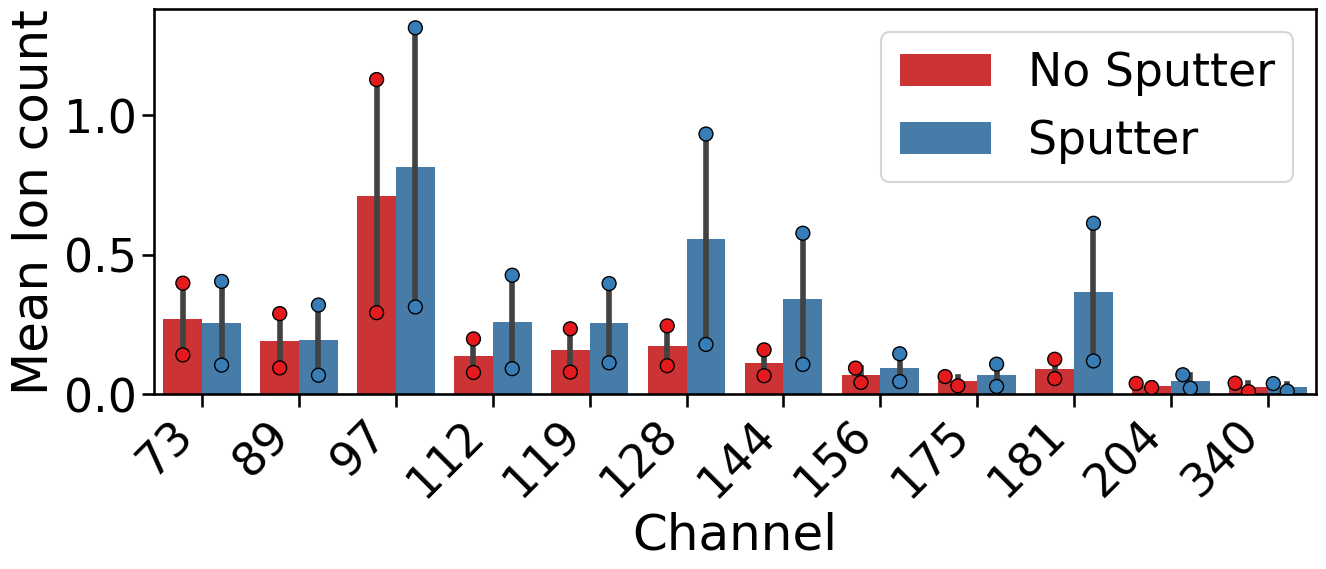

In [48]:
# Cell region mean intensity
df_subset = df.iloc[:,[0,1,3]].melt(id_vars=['Type', 'Channel'], value_name='Intensity')
df_subset.head()

hue_plot_params = {
    'data':      df_subset,
    'x':         'Channel',
    'y':         'Intensity',
    "hue":       "Type",
    "palette":   "Set1"
}

# Plot
fig, ax = plt.subplots(figsize=(15, 5))
ax = sns.barplot(**hue_plot_params)
ax = sns.swarmplot(**hue_plot_params, dodge=True, edgecolor='k', linewidth=1.0, size=10)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:])
ax.set_ylabel("Mean Ion count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# # Anotation paris
# pairs = [[(channel, 'FFPE'), (channel, 'OCT')] for channel in channels] 

# # Add annotations
# annotator = Annotator(ax, pairs, **hue_plot_params)
# annotator.configure(test='Wilcoxon', verbose=True)
# _, results = annotator.apply_and_annotate()


In [49]:
df.to_clipboard()

[Text(0, 0, '73'),
 Text(1, 0, '89'),
 Text(2, 0, '97'),
 Text(3, 0, '112'),
 Text(4, 0, '119'),
 Text(5, 0, '128'),
 Text(6, 0, '144'),
 Text(7, 0, '156'),
 Text(8, 0, '175'),
 Text(9, 0, '181'),
 Text(10, 0, '204'),
 Text(11, 0, '340')]

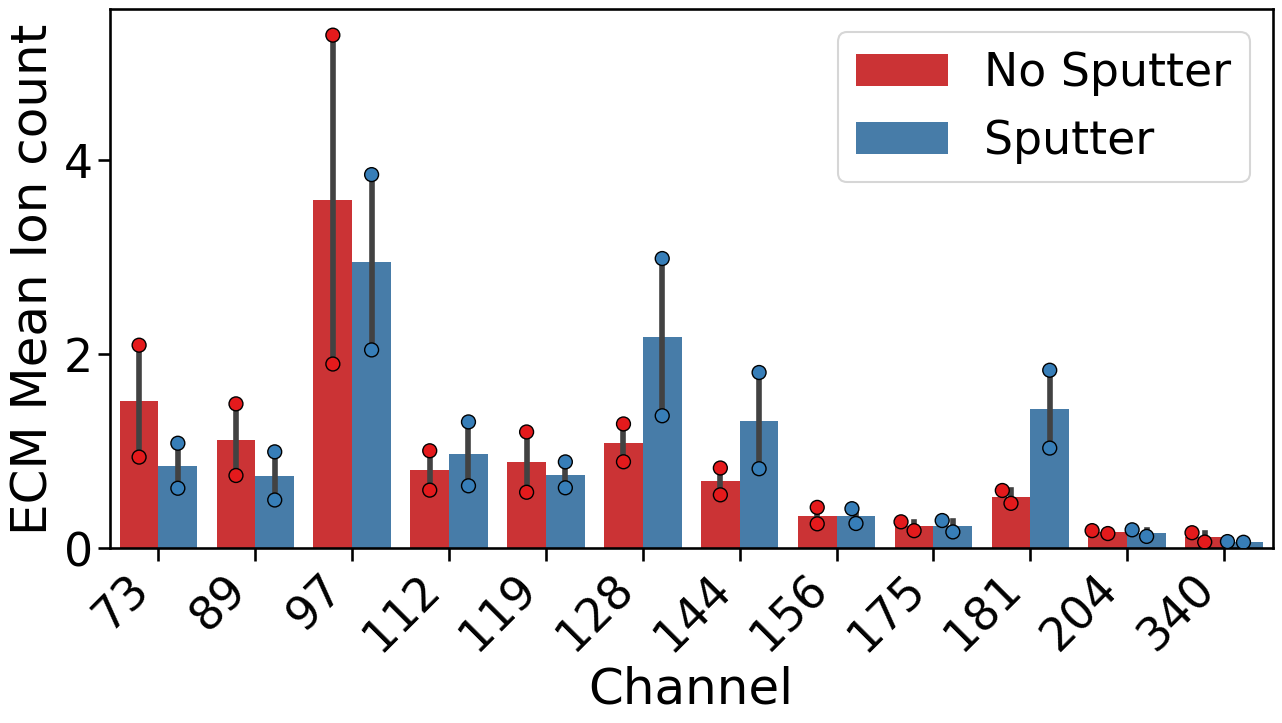

In [16]:
# ECM region mean intensity
df_subset = df.iloc[:,[0,1,4]].melt(id_vars=['Type', 'Channel'], value_name='Intensity')
df_subset.head()

hue_plot_params = {
    'data':      df_subset,
    'x':         'Channel',
    'y':         'Intensity',
    "hue":       "Type",
    "palette":   "Set1"
}

# Plot
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.barplot(**hue_plot_params)
ax = sns.swarmplot(**hue_plot_params, dodge=True, edgecolor='k', linewidth=1.0, size=10)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[-2:], labels[-2:])
ax.set_ylabel("ECM Mean Ion count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# # Anotation paris
# pairs = [[(channel, 'FFPE'), (channel, 'OCT')] for channel in channels] 

# # Add annotations
# annotator = Annotator(ax, pairs, **hue_plot_params)
# annotator.configure(test='Wilcoxon', verbose=True)
# _, results = annotator.apply_and_annotate()


ValueError: min() arg is an empty sequence

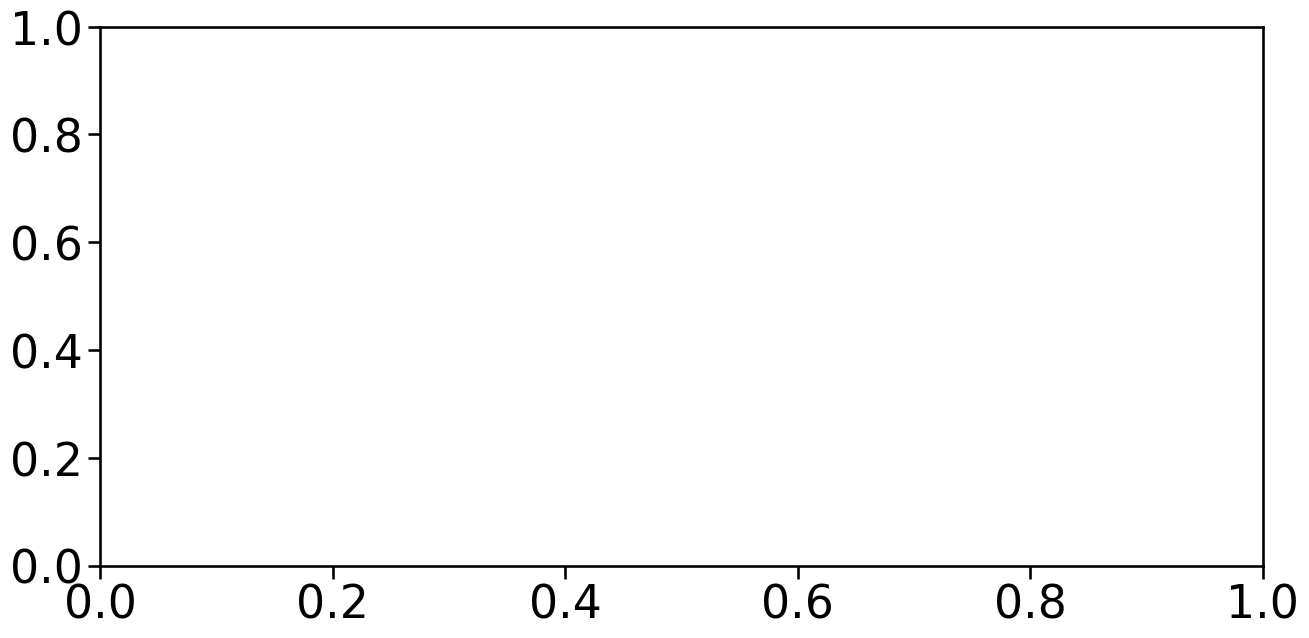

In [18]:
# Fold Change cell region
df_subset = df.iloc[:,[0,1,3]].melt(id_vars=['Type', 'Channel'], value_name='Intensity')
df_subset = df_subset.groupby(['Type', 'Channel', 'variable'])['Intensity'].mean().reset_index()
df_fold = df_subset[df_subset['Type'] == 'OCT']
df_fold['Fold Change'] = df_subset[df_subset['Type'] == 'OCT']['Intensity'].values / df_subset[df_subset['Type'] == 'FFPE']['Intensity'].values
df_fold['Fold Change'] = np.log2(df_fold['Fold Change'])
df_fold['Channel'] = df_fold['Channel'].astype(int)
df_fold.sort_values('Channel')

hue_plot_params = {
    'data':      df_fold,
    'x':         'Channel',
    'y':         'Fold Change',
    "palette":   "Set1"

}

# Plot
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.barplot(**hue_plot_params)
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("Cell Mean Ion count Fold Change (log2)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


ValueError: min() arg is an empty sequence

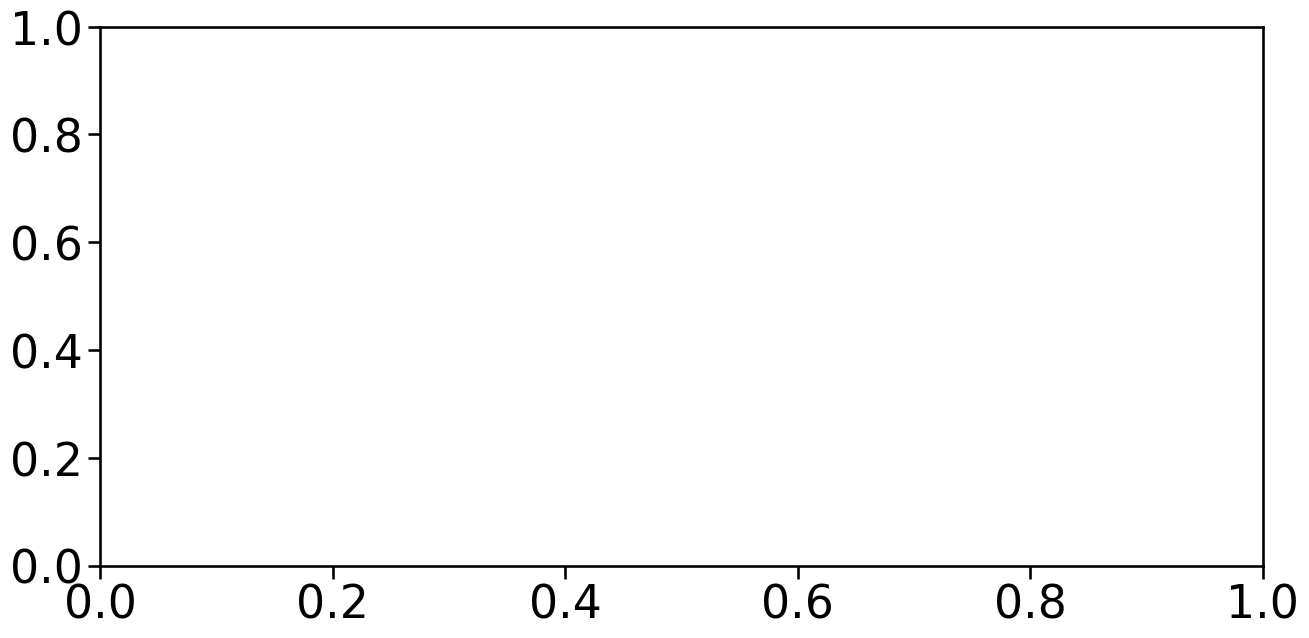

In [19]:
# Fold Change ECM region
df_subset = df.iloc[:,[0,1,4]].melt(id_vars=['Type', 'Channel'], value_name='Intensity')
df_subset = df_subset.groupby(['Type', 'Channel', 'variable'])['Intensity'].mean().reset_index()
df_fold = df_subset[df_subset['Type'] == 'OCT']
df_fold['Fold Change'] = df_subset[df_subset['Type'] == 'OCT']['Intensity'].values / df_subset[df_subset['Type'] == 'FFPE']['Intensity'].values
df_fold['Fold Change'] = np.log2(df_fold['Fold Change'])
df_fold['Channel'] = df_fold['Channel'].astype(int)
df_fold.sort_values('Channel')

hue_plot_params = {
    'data':      df_fold,
    'x':         'Channel',
    'y':         'Fold Change',
        "palette":   "Set1"

}

# Plot
fig, ax = plt.subplots(figsize=(15, 7))
ax = sns.barplot(**hue_plot_params)
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("Cell Mean Ion count Fold Change (log2)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


ValueError: Missing hue value `FFPE` in Type (specified in `pairs`)

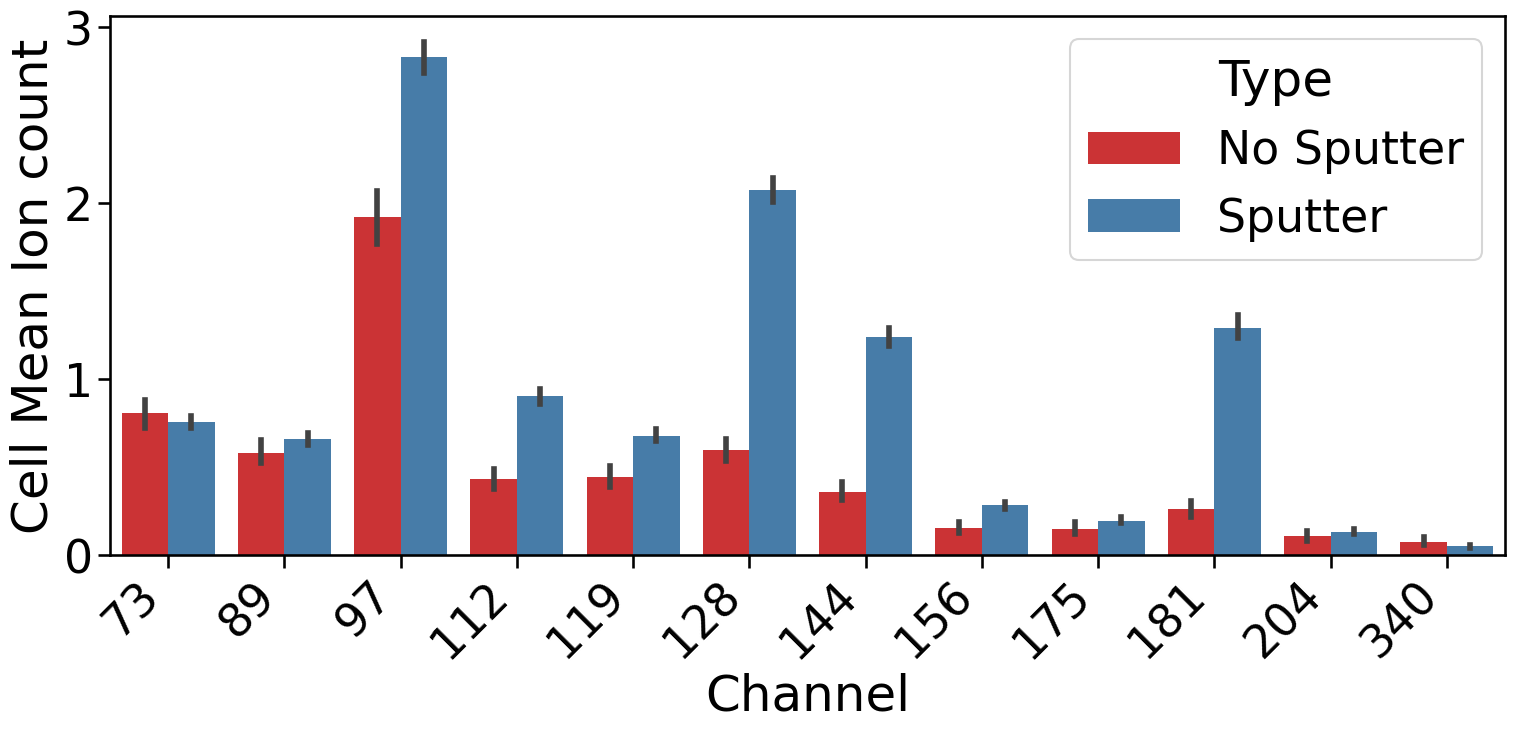

In [20]:
# Mean intensity per cell
df_subset = df_prop.iloc[:,[1,2,4]].melt(id_vars=['Type', 'Channel'], value_name='Intensity')
df_subset.head()

hue_plot_params = {
    'data':      df_subset,
    'x':         'Channel',
    'y':         'Intensity',
    "hue":       "Type",
    "palette":   "Set1"
}

# Plot
fig, ax = plt.subplots(figsize=(18, 7))
ax = sns.barplot(**hue_plot_params)
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("Cell Mean Ion count")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Anotation paris
pairs = [[(channel, 'FFPE'), (channel, 'OCT')] for channel in channels] 

# Add annotations
annotator = Annotator(ax, pairs, **hue_plot_params)
annotator.configure(test='Mann-Whitney', verbose=True)
_, results = annotator.apply_and_annotate()


ValueError: min() arg is an empty sequence

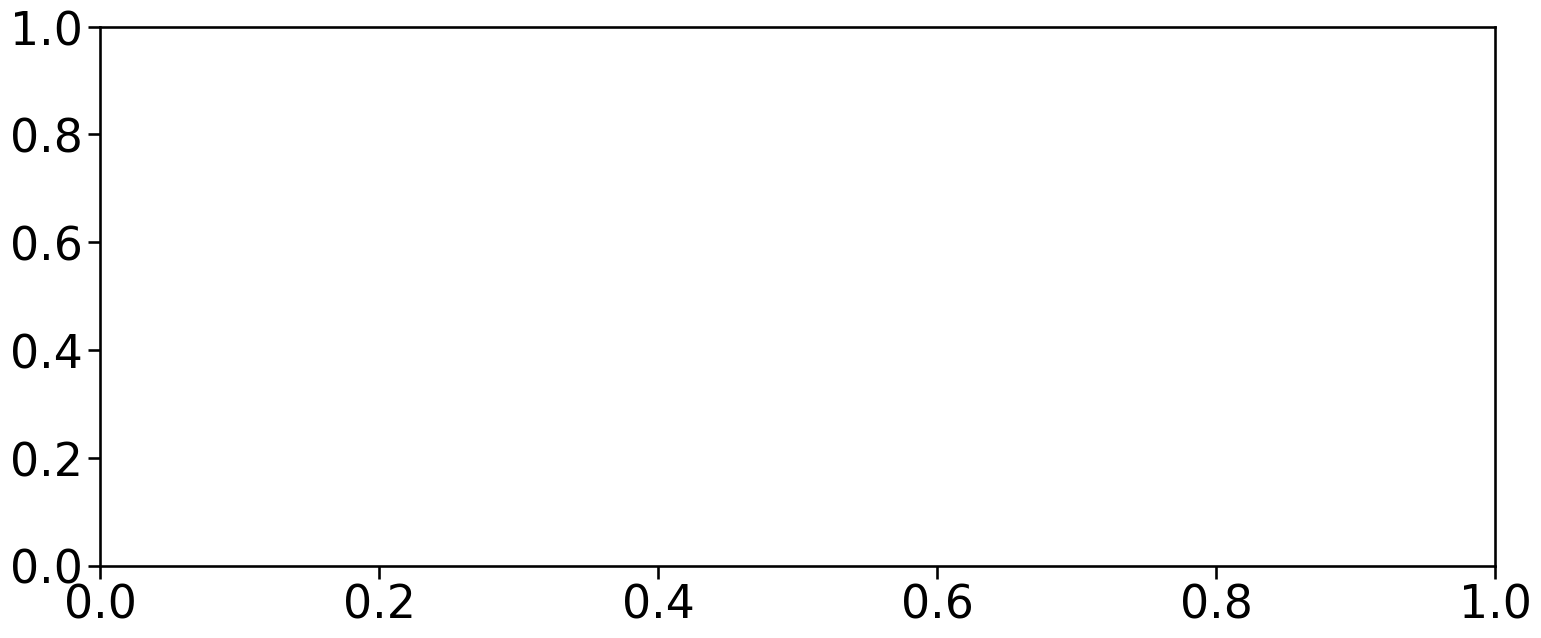

In [21]:
df_subset = df_prop.iloc[:,[1,2,4]].melt(id_vars=['Type', 'Channel'], value_name='Intensity')
df_subset = df_subset.groupby(['Type', 'Channel', 'variable'])['Intensity'].mean().reset_index()
df_fold = df_subset[df_subset['Type'] == 'OCT']
df_fold['Fold Change'] = df_subset[df_subset['Type'] == 'OCT']['Intensity'].values / df_subset[df_subset['Type'] == 'FFPE']['Intensity'].values
df_fold['Fold Change'] = np.log2(df_fold['Fold Change'])
df_fold['Channel'] = df_fold['Channel'].astype(int)
df_fold.sort_values('Channel')

hue_plot_params = {
    'data':      df_fold,
    'x':         'Channel',
    'y':         'Fold Change',
    "palette":   "tab10"

}

# Plot
fig, ax = plt.subplots(figsize=(18, 7))
ax = sns.barplot(**hue_plot_params)
handles, labels = ax.get_legend_handles_labels()
ax.set_ylabel("Mean Ion count Fold Change (log2)")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
